# Подготовка ДФ

In [ ]:
from google.colab import files, drive
import gdown
from os import path
import pickle as pkl
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Media_108/ДФ/result_df.csv')

In [ ]:
# Выборка с текстами транскрибации и классом звонка
df = data[['Класс', 'Транскрибированный текст']]
df.shape

(6924, 2)

<Axes: >

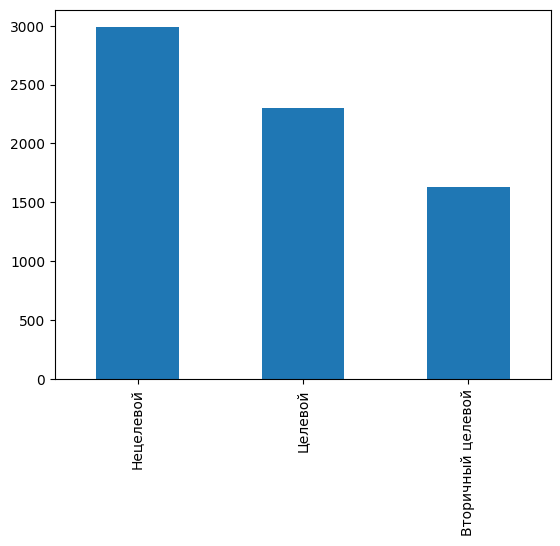

In [ ]:
df['Класс'].value_counts().plot.bar()

In [ ]:
df_copy = df.copy()

In [ ]:
# Преобразуем значения класса в число
df_copy.loc[df_copy['Класс'] == 'Нецелевой', 'Класс'] = 0
df_copy.loc[df_copy['Класс'] == 'Целевой', 'Класс'] = 1
df_copy.loc[df_copy['Класс'] == 'Вторичный целевой', 'Класс'] = 1

In [ ]:
print(df_copy['Класс'].values)

[0 0 0 ... 0 0 0]


<Axes: >

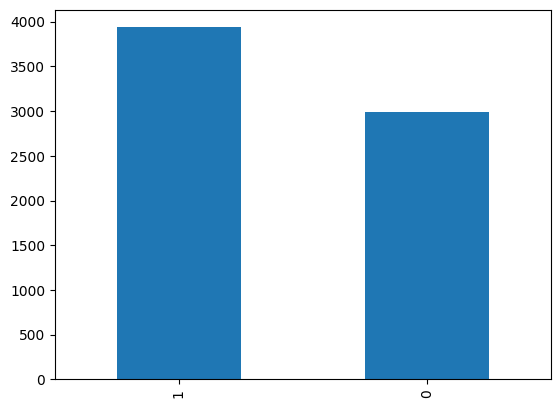

In [ ]:
# Соотношение классов
df_copy['Класс'].value_counts().plot.bar()

In [ ]:
df_copy.to_pickle('/content/drive/MyDrive/Media_108/ДФ/result_df_num_classes.pkl')

# Создание модели

In [ ]:
!pip install autokeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import autokeras as ak
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [ ]:
# Загрузка датафрейма
df_model = pd.read_pickle('/content/drive/MyDrive/Media_108/ДФ/result_df_num_classes.pkl')

# Разделение датафрейма на признаки и целевую переменную
X = df_model['Транскрибированный текст']
y = df_model['Класс']

# Разделение выборки на тренировочную, валидационную и тестовую
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Примерное соотношение: 70% для тренировочной, 15% для валидационной и 15% для тестовой выборки

In [ ]:
# Преобразование признаков в массивы NumPy
X_train = X_train.values.astype(str)
X_val = X_val.values.astype(str)
X_test = X_test.values.astype(str)

y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [ ]:
# Создание экземпляра векторизатора TF-IDF
vectorizer = TfidfVectorizer()

# Преобразование текстовых данных в векторное представление
X_train = vectorizer.fit_transform(X_train).toarray()
X_val = vectorizer.transform(X_val).toarray()

In [ ]:
batch_size = 32
num_batches = len(X_train) // batch_size

# Создание и обучение модели AutoKeras долями
clf = ak.TextClassifier(max_trials=10) # max_trials - максимальное количество итераций для обучения

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    X_batch = X_train[start:end]
    y_batch = y_train[start:end]

    X_batch = np.expand_dims(X_batch[:, -1], axis=1)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_batch, y_batch))

    clf.fit(train_dataset, validation_data=val_dataset)

# Проверка на валидационной выборке
X_val = np.expand_dims(X_val[:, -1], axis=1)  # Изменение формы данных
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

clf.evaluate(val_dataset)

TypeError: ignored

In [ ]:
va

In [ ]:
# Оценка качества модели на тестовых данных
accuracy = clf.evaluate(X_test, y_test)[1]
print('Accuracy:', accuracy)

# Предсказание меток классов на тестовых данных
y_pred = clf.predict(X_test)

In [ ]:
# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:', cm)

In [ ]:
# Сохранение весов модели
clf.export_model().save('/content/drive/MyDrive/Media_108/AutoKeras/model_autokeras.h5')